In [1]:
import torch
import numpy as np
import scipy.stats
import scipy.cluster
import scipy.cluster.hierarchy
import sklearn.cluster
import sklearn.decomposition
import sklearn.datasets
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from model import StyledGenerator

In [2]:
# Plotting defaults
font_manager.fontManager.ttflist.extend(
    font_manager.createFontList(
        font_manager.findSystemFonts(fontpaths="/users/amtseng/modules/fonts")
    )
)
plot_params = {
    "figure.titlesize": 24,
    "axes.titlesize": 18,
    "axes.labelsize": 18,
    "legend.fontsize": 18,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

In [3]:
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Load model

In [4]:
model = StyledGenerator(512).to(DEVICE)  # 512 is code dimension
step = int(np.log2(1024)) - 2  # Helps define model's output size
model.load_state_dict(torch.load("stylegan-1024px-new.model")["g_running"])  # TODO
model = model.eval()

### Generate example images from code `z`

In [5]:
def generate_samples(num_samples):
    """
    Generates `num_samples` samples from the model. Returns a NumPy array
    of shape N x 1024 x 1024 x 3. Images will be rescaled to the [0, 1]
    range and clipped.
    """
    with torch.no_grad():
        samples = model(
            torch.randn(num_samples, 512).to(DEVICE),
            step=step, alpha=1
        )
        samples = samples.permute(0, 2, 3, 1).cpu().numpy()
    return np.clip((samples + 1) / 2, 0, 1)

In [6]:
samples = generate_samples(10)

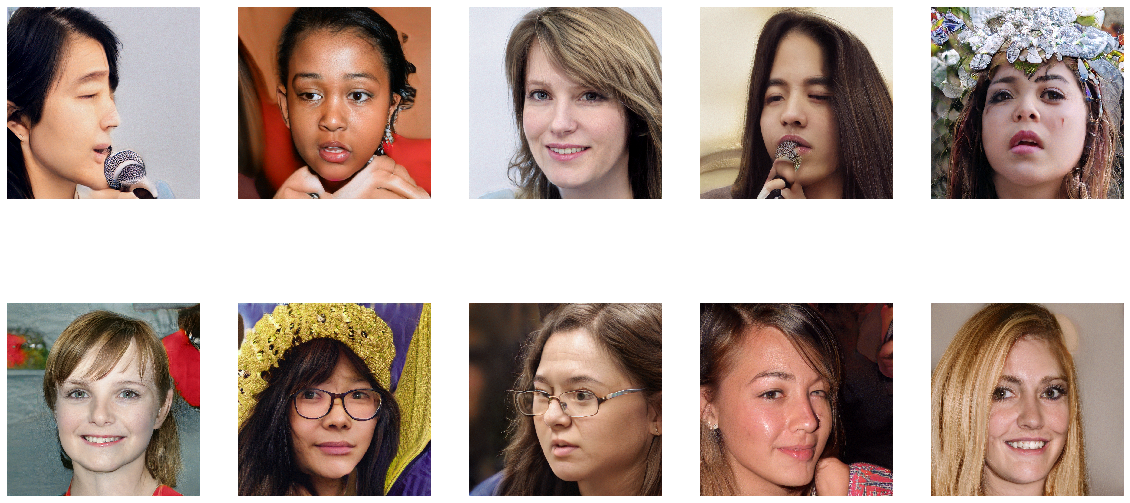

In [7]:
num_rows, num_cols = 2, 5
fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 10))
for i in range(num_rows * num_cols):
    r, c = i // num_cols, i % num_cols
    ax[r][c].imshow(samples[i])
    ax[r][c].axis("off")
plt.show()
fig.savefig("figures/random_faces.svg", format="svg")

### Examine distribution of style `w`

In [8]:
with torch.no_grad():
    w = model.style(torch.randn(64, 512).to(DEVICE)).cpu().numpy()

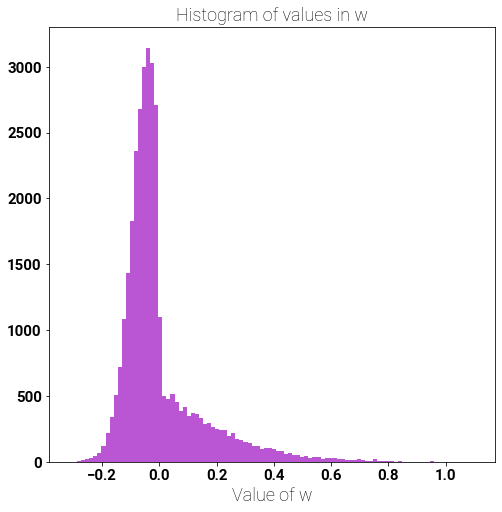

In [9]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.hist(np.ravel(w), bins=100, color="mediumorchid")
ax.set_xlabel("Value of w")
ax.set_title("Histogram of values in w")
plt.show()
fig.savefig("figures/w_hist.svg", format="svg")

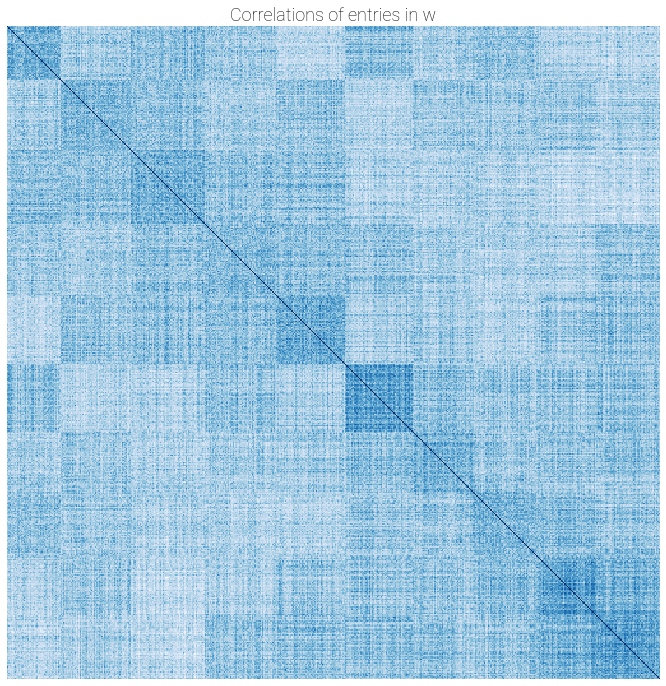

In [10]:
corr_matrix = np.corrcoef(w, rowvar=False)

# Find good ordering of correlation matrix
kmeans_clusters = 10
kmeans = sklearn.cluster.KMeans(n_clusters=kmeans_clusters)
cluster_assignments = kmeans.fit_predict(corr_matrix)
kmeans_centers = kmeans.cluster_centers_
cluster_order = scipy.cluster.hierarchy.leaves_list(
    scipy.cluster.hierarchy.optimal_leaf_ordering(
        scipy.cluster.hierarchy.linkage(kmeans_centers, method="centroid"), kmeans_centers
    )
)
cluster_inds = []
for cluster_id in cluster_order:
    cluster_inds.append(np.where(cluster_assignments == cluster_id)[0])
cluster_inds = np.concatenate(cluster_inds)
corr_matrix = corr_matrix[cluster_inds][:, cluster_inds]

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(corr_matrix, cmap="Blues")
ax.set_title("Correlations of entries in w")
ax.axis("off")
plt.show()
fig.savefig("figures/w_corr.svg", format="svg")

### Generate samples from different eigenvectors of `w`

In [11]:
def generate_samples_from_w(w):
    """
    Generates samples from the model starting with an N x 512 tensor.
    Returns a NumPy array of shape N x 1024 x 1024 x 3.
    Images will be rescaled to the [0, 1] range and clipped.
    """
    with torch.no_grad():
        noise = [
            torch.randn(w.shape[0], 1, 4 * (2 ** i), 4 * (2 ** i), device=DEVICE)
            for i in range(step + 1)
        ]
        samples = model.generator([w], noise, step=step, alpha=1)
        samples = samples.permute(0, 2, 3, 1).detach().cpu().numpy()
    return np.clip((samples + 1) / 2, 0, 1)

In [12]:
# Generate many samples of w
with torch.no_grad():
    w = model.style(torch.randn(2000, 512).to(DEVICE)).cpu().numpy()

In [13]:
# Run PCA
num_pcs = 100
w_means = np.mean(w, axis=0)
w_centered = w - w_means[None]
# We will keep around `w_means` to transform things back to this space later

pca = sklearn.decomposition.PCA(num_pcs)
pca.fit(w_centered)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

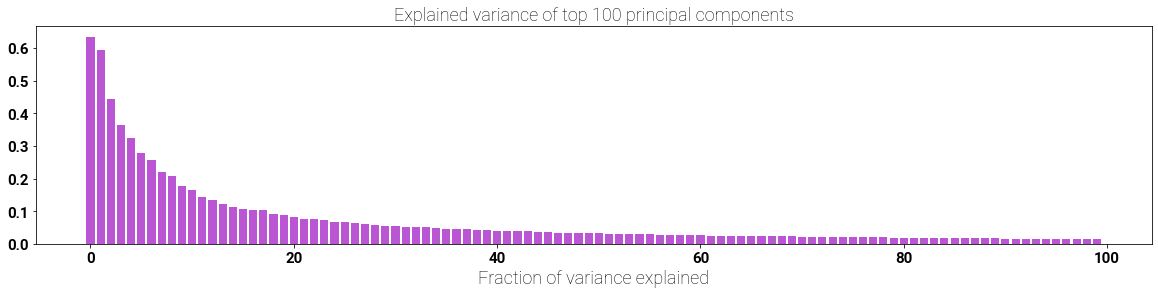

In [14]:
fig, ax = plt.subplots(figsize=(20, 4))
explained_var = pca.explained_variance_
ax.bar(np.arange(num_pcs), explained_var[:num_pcs], color="mediumorchid")
ax.set_title("Explained variance of top %d principal components" % num_pcs)
ax.set_xlabel("Fraction of variance explained")
plt.show()
fig.savefig("figures/face_pca_variance.svg", format="svg")

PC 0


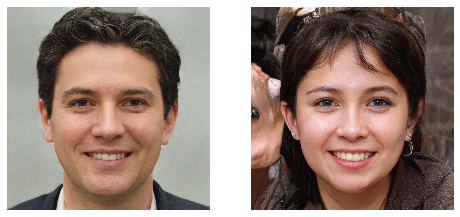

PC 1


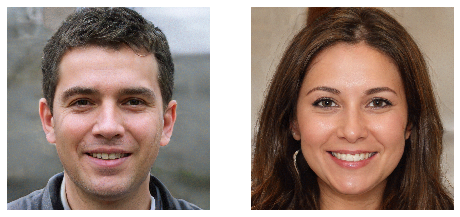

PC 2


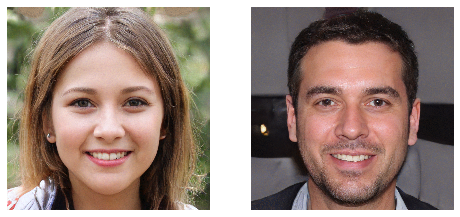

PC 3


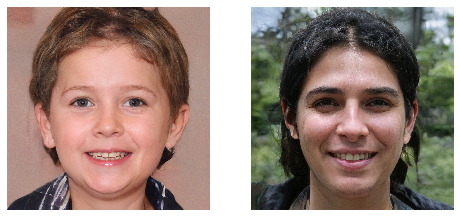

PC 4


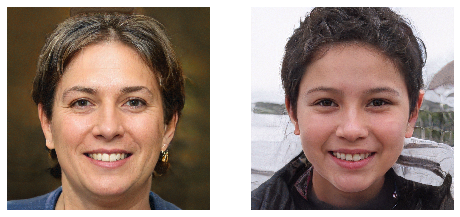

PC 5


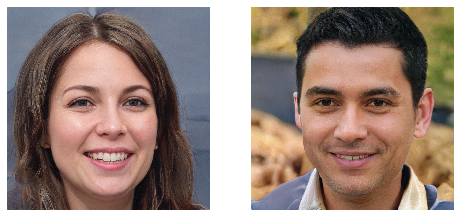

PC 6


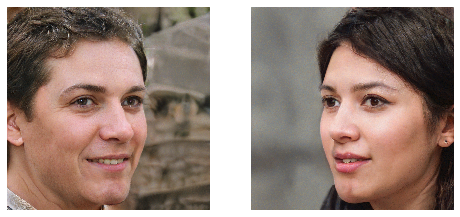

PC 7


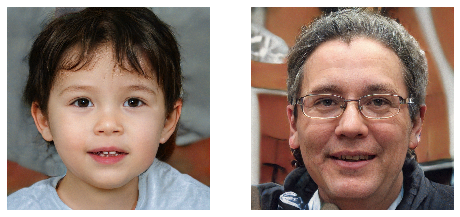

PC 8


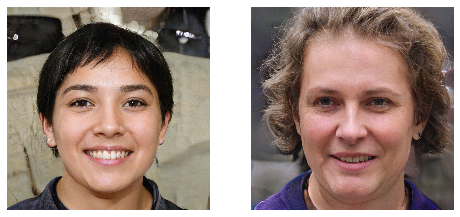

PC 9


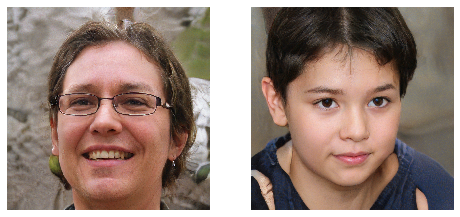

In [15]:
eigenvecs = pca.components_

for pc_i in range(10):
    eigenvec = eigenvecs[pc_i]

    eigenspace_vecs = np.zeros((2, num_pcs))
    eigenspace_vecs[0, pc_i] = 1
    eigenspace_vecs[1, pc_i] = -1
    test_w = pca.inverse_transform(eigenspace_vecs) + w_means
    test_w = torch.tensor(test_w, device=DEVICE).float()

    samples = generate_samples_from_w(test_w)
    
    print("PC %d" % pc_i)
    fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
    for i in range(2):
        ax[i].imshow(samples[i])
        ax[i].axis("off")
    plt.show()
    fig.savefig("figures/face_pca_pc%d.svg" % pc_i, format="svg")

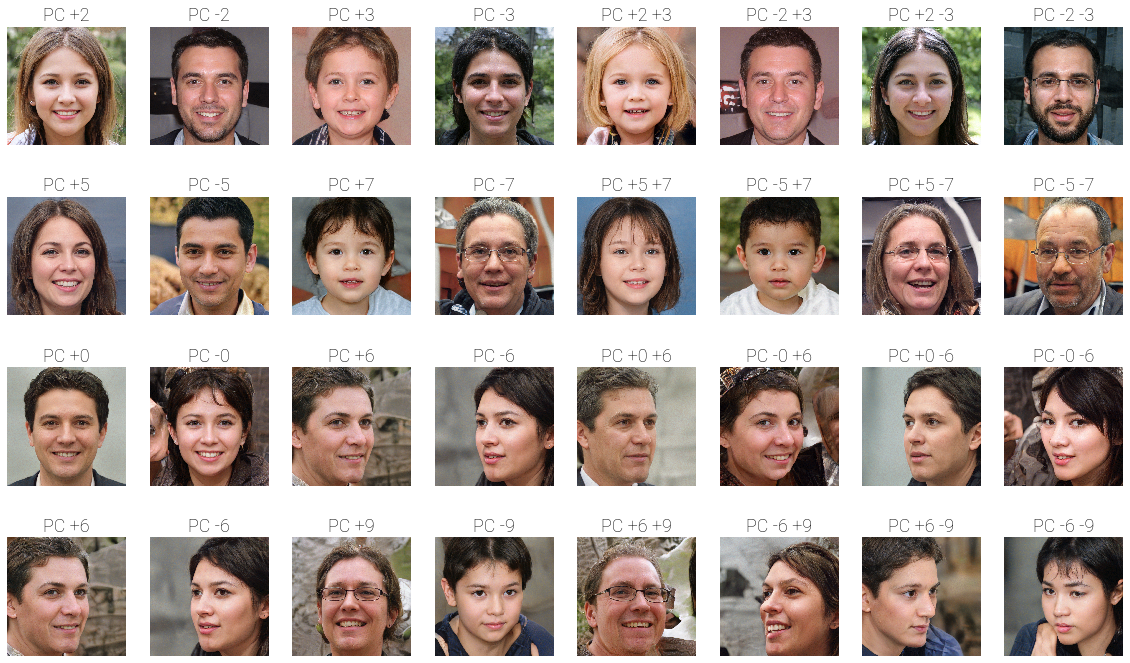

In [16]:
# Try some mixtures
mixtures = [(2, 3), (5, 7), (0, 6), (6, 9)]
eigenspace_vecs = np.zeros((8 * len(mixtures), num_pcs))
for i, (pc_i, pc_j) in enumerate(mixtures):
    eigenspace_vecs[(i * 8), pc_i] = 1
    eigenspace_vecs[(i * 8) + 1, pc_i] = -1
    eigenspace_vecs[(i * 8) + 2, pc_j] = 1
    eigenspace_vecs[(i * 8) + 3, pc_j] = -1
    eigenspace_vecs[(i * 8) + 4, pc_i] = 1
    eigenspace_vecs[(i * 8) + 4, pc_j] = 1
    eigenspace_vecs[(i * 8) + 5, pc_i] = -1
    eigenspace_vecs[(i * 8) + 5, pc_j] = 1
    eigenspace_vecs[(i * 8) + 6, pc_i] = 1
    eigenspace_vecs[(i * 8) + 6, pc_j] = -1
    eigenspace_vecs[(i * 8) + 7, pc_i] = -1
    eigenspace_vecs[(i * 8) + 7, pc_j] = -1
    
test_w = pca.inverse_transform(eigenspace_vecs) + w_means
test_w = torch.tensor(test_w, device=DEVICE).float()

samples = generate_samples_from_w(test_w)

fig, ax = plt.subplots(nrows=len(mixtures), ncols=8, figsize=(20, 3 * len(mixtures)))
for i, (pc_i, pc_j) in enumerate(mixtures):
    for j in range(8):
        ax[i][j].imshow(samples[(i * 8) + j])
        ax[i][j].axis("off")
    ax[i][0].set_title("PC +%d" % pc_i)
    ax[i][1].set_title("PC -%d" % pc_i)
    ax[i][2].set_title("PC +%d" % pc_j)
    ax[i][3].set_title("PC -%d" % pc_j)
    ax[i][4].set_title("PC +%d +%d" % (pc_i, pc_j))
    ax[i][5].set_title("PC -%d +%d" % (pc_i, pc_j))
    ax[i][6].set_title("PC +%d -%d" % (pc_i, pc_j))
    ax[i][7].set_title("PC -%d -%d" % (pc_i, pc_j))
plt.show()
fig.savefig("figures/face_pca_mixes.svg", format="svg")

### Wine dataset

In [17]:
wine_data = sklearn.datasets.load_wine()

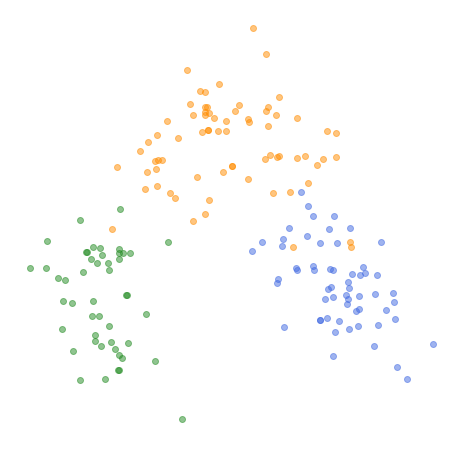

In [18]:
wine_pca = sklearn.decomposition.PCA(2)
wine_means = np.mean(wine_data["data"], axis=0)
wine_stds = np.std(wine_data["data"], axis=0)
wine_whitened = (wine_data["data"] - wine_means) / wine_stds
wine_transformed = wine_pca.fit_transform(wine_whitened)

fig, ax = plt.subplots(figsize=(8, 8))
colors = ["royalblue", "darkorange", "forestgreen"]
for i in np.unique(wine_data["target"]):
    inds = wine_data["target"] == i
    x, y = wine_transformed[inds, 0], wine_transformed[inds, 1]
    ax.scatter(x, y, color=colors[i], alpha=0.5)
ax.axis("off")
plt.show()
fig.savefig("figures/wine_pca.svg", format="svg")

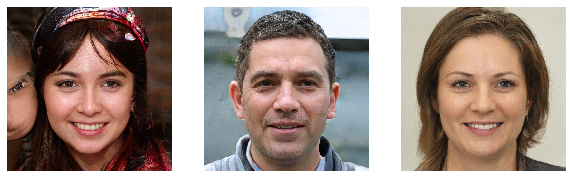

In [19]:
# Visualize a few points in face space
face_pca = sklearn.decomposition.PCA(2)
face_transformed = face_pca.fit_transform(w_centered)

wine_transformed_scaled = ((
    (wine_transformed - np.mean(wine_transformed, axis=0)) / np.std(wine_transformed, axis=0)
) * np.std(face_transformed, axis=0)) + np.mean(face_transformed, axis=0)

wine_face_aligned_w = face_pca.inverse_transform(wine_transformed_scaled) + w_means
inds = np.array([
    np.argmin(wine_transformed[:, 0]),
    np.argmax(wine_transformed[:, 1]),
    np.argmax(wine_transformed[:, 0])
])

wine_face_aligned_samples = generate_samples_from_w(torch.tensor(wine_face_aligned_w[inds], device=DEVICE).float())
    
fig, ax = plt.subplots(ncols=3, figsize=(10, 4))
for i in range(3):
    ax[i].imshow(wine_face_aligned_samples[i])
    ax[i].axis("off")
plt.show()
fig.savefig("figures/wine_pca_faces.svg", format="svg")

### KGP dataset

In [20]:
kgp_obj = np.load("kgp/chr22_variant_file.npz")
sample_ids = kgp_obj["header"]
variants = kgp_obj["variants"]

In [21]:
sample_mapper = {}
with open("kgp/igsr_samples.tsv", "r") as f:
    next(f)
    for line in f:
        tokens = line.split("\t")
        sample_mapper[tokens[0]] = tokens[5]

In [22]:
sample_pops = np.array([sample_mapper[s] for s in sample_ids])

# For simplicity, remove the single EUR,AFR individual
inds = sample_pops != "EUR,AFR"
variants, sample_pops = variants[inds], sample_pops[inds]

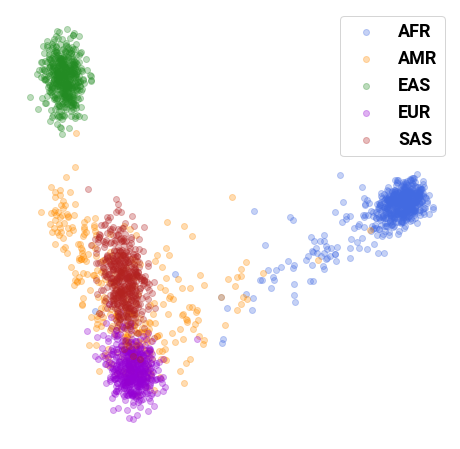

In [23]:
kgp_pca = sklearn.decomposition.PCA(100)
kgp_means = np.mean(variants, axis=0)
kgp_centered = variants - kgp_means
kgp_transformed = kgp_pca.fit_transform(kgp_centered)

fig, ax = plt.subplots(figsize=(8, 8))
colors = ["royalblue", "darkorange", "forestgreen", "darkviolet", "firebrick"]
for i, pop in enumerate(np.unique(sample_pops)):
    inds = sample_pops == pop
    x, y = kgp_transformed[inds, 0], kgp_transformed[inds, 1]
    ax.scatter(x, y, color=colors[i], alpha=0.3, label=pop)
ax.legend()
ax.axis("off")
plt.show()
fig.savefig("figures/kgp_pca.svg", format="svg")

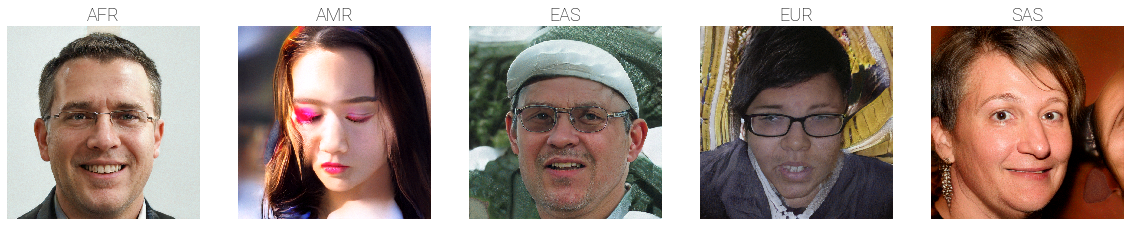

In [24]:
# Visualize a few points in face space
face_pca = sklearn.decomposition.PCA(100)
face_transformed = face_pca.fit_transform(w_centered)

pop_centroids = []
pop_list = np.unique(sample_pops)
for pop in pop_list:
    inds = sample_pops == pop
    centroid = np.mean(kgp_transformed[inds], axis=0)
    pop_centroids.append(centroid)
pop_centroids = np.stack(pop_centroids, axis=0)

kgp_transformed_scaled = ((
    (pop_centroids - np.mean(pop_centroids, axis=0)) / np.std(pop_centroids, axis=0)
) * np.std(face_transformed, axis=0)) + np.mean(face_transformed, axis=0)

kgp_face_aligned_w = face_pca.inverse_transform(kgp_transformed_scaled) + w_means

kgp_face_aligned_samples = generate_samples_from_w(torch.tensor(kgp_face_aligned_w, device=DEVICE).float())
    
fig, ax = plt.subplots(ncols=len(pop_centroids), figsize=(20, 4))
for i in range(len(pop_centroids)):
    ax[i].imshow(kgp_face_aligned_samples[i])
    ax[i].set_title(pop_list[i])
    ax[i].axis("off")
plt.show
fig.savefig("figures/kgp_pca_faces.svg", format="svg")